# Code to impute emissions rates, then take model output and generate total emissions by year
The first challenge will be to get emissions rates (lb/mwh).  To do this I'll be taking EIA data on net generation and EPA data on emissions to calculate rates.  There will be many missings that I will fill in by taking capacity-weighted technology-planning_year means.

Once I have emissions rates, the goal will be to output a series of shapefiles of location-specific aggregate emissions by year. A challenge here is taking production from the scenario outputs and assigning it to specific plants.  I assign production based on capacity.

### Brief Code Overview
1. Data cleaning (formatting columns, names, etc)
2. Merge EIA and EPA data into existing_gen_units using the EPA-EIA crosswalk. 
3. Impute generation for generators with missing generation.  To do this, I take plant-level generation and distribute that generation to generators based on each generator's capacity.
4. Calculate generation-weighted average emissions rates, then use those to fill in generators with missing emissions rates (missings get filled in with a technology-planningyear weighted mean).
5. Calculate aggregate emissions by multiplying rates by model-output specified generation.  As mentioned earlier, I calculate generator level generation either by calculating a generator's share of total capacity or net generation for that cluster-planningyear.
6. Split the emissions output by planning year and write to shapefiles.


## 1. Data cleaning

In [105]:
globals().clear()

import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import geopandas as gpd
import fiona
import math
from shapely.geometry import Point

In [106]:
os.chdir('C:/Users/lbeatty/Documents/Lauren_MIP_Contribution/')


#PG existing gen units output
existing_gen_units_2030 = pd.read_csv('MIP_results_comparison/case_settings/26-zone/usensys-inputs-short/usensys-inputs-short/2030/base_short_2030/extra_outputs/existing_gen_units.csv')
existing_gen_units_2040 = pd.read_csv('MIP_results_comparison/case_settings/26-zone/usensys-inputs-short/usensys-inputs-short/2040/base_short_2040/extra_outputs/existing_gen_units.csv')
existing_gen_units_2050 = pd.read_csv('MIP_results_comparison/case_settings/26-zone/usensys-inputs-short/usensys-inputs-short/2050/base_short_2050/extra_outputs/existing_gen_units.csv')


#filter by retirement year
#the code was written when existing_gen_units varied by year so lots of artifacts of the way the old output looked
existing_gen_units_2030 = existing_gen_units_2030.query('retirement_year>=2030')
existing_gen_units_2040 = existing_gen_units_2030.query('retirement_year>=2040')
existing_gen_units_2050 = existing_gen_units_2030.query('retirement_year>=2050')


#EIA-EPA Crosswalk
crosswalk = pd.read_csv("Data/epa_eia_crosswalk.csv")

# EIA 860 for Generator Info
eia860 = pd.read_excel("Data/eia860/3_1_Generator_Y2020.xlsx", skiprows=1)

# EIA923 for Generation Info
eia923_fuels = pd.read_excel("Data/eia923/EIA923_Schedules_2_3_4_5_M_12_2020_Final_Revision.xlsx", sheet_name='Page 1 Generation and Fuel Data', skiprows=5)
eia923_generators = pd.read_excel("Data/eia923/EIA923_Schedules_2_3_4_5_M_12_2020_Final_Revision.xlsx", sheet_name='Page 4 Generator Data', skiprows=5)

#Emissions
emissions = pd.read_csv("Data/CAMD/facilities_emissions.csv")
#only want year 2020
emissions = emissions.query('year==2020')

# PM25
pm25 = pd.read_excel("Data/eGRID2020 DRAFT PM Emissions.xlsx", sheet_name="2020 PM Unit-level Data", skiprows=1)


C:\Users\lbeatty\AppData\Local\Temp\ipykernel_804\924493314.py:5: DtypeWarning: Columns (17,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  existing_gen_units_2030 = pd.read_csv('MIP_results_comparison/case_settings/26-zone/usensys-inputs-short/usensys-inputs-short/2030/base_short_2030/extra_outputs/existing_gen_units.csv')
C:\Users\lbeatty\AppData\Local\Temp\ipykernel_804\924493314.py:6: DtypeWarning: Columns (17,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  existing_gen_units_2040 = pd.read_csv('MIP_results_comparison/case_settings/26-zone/usensys-inputs-short/usensys-inputs-short/2040/base_short_2040/extra_outputs/existing_gen_units.csv')
C:\Users\lbeatty\AppData\Local\Temp\ipykernel_804\924493314.py:7: DtypeWarning: Columns (17,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  existing_gen_units_2050 = pd.read_csv('MIP_results_comparison/case_settings/26-zone/usensys-inputs-shor

In [107]:
#############################
## Read in and format NEI ####
###############################

#nei data gives values for ammonia, vocs, and also pm2.5
#It also has so2 and nox output that mostly matches camd data
#I'll prioritise camd data, but fill in any missings with nei

#cems noncems just distinguish whether emissions were continuously monitored or imputed
#doesn't really matter for our purposes
nei_cems = pd.read_csv('Data/NEI/egucems_SmokeFlatFile_2020NEI_POINT_20230128_27mar2023_v1.csv', skiprows=16)
nei_noncems = pd.read_csv('Data/NEI/egunoncems_SmokeFlatFile_2020NEI_POINT_20230128_27mar2023_v0.csv', skiprows=15)
nei = pd.concat([nei_cems, nei_noncems])

#pull out the relevant pollutants
nei = nei.groupby(['oris_facility_code', 'oris_boiler_id', 'poll']).agg({'ann_value': 'sum'}).reset_index()
nei = nei[nei['poll'].isin(['CO', 'NH3', 'NOX', 'PM25-PRI', 'SO2', 'SO4', 'VOC'])]

#put weights in pounds
nei['poll']=nei['poll']+'_nei_tons'
nei['ann_value']=nei['ann_value']
nei = nei.pivot(index=['oris_facility_code', 'oris_boiler_id'], columns='poll', values='ann_value').reset_index()
nei = nei.rename(columns = {'oris_facility_code': 'CAMD_PLANT_ID', 'oris_boiler_id': 'CAMD_UNIT_ID'})



C:\Users\lbeatty\AppData\Local\Temp\ipykernel_804\2972420735.py:11: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  nei_cems = pd.read_csv('Data/NEI/egucems_SmokeFlatFile_2020NEI_POINT_20230128_27mar2023_v1.csv', skiprows=16)
C:\Users\lbeatty\AppData\Local\Temp\ipykernel_804\2972420735.py:12: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  nei_noncems = pd.read_csv('Data/NEI/egunoncems_SmokeFlatFile_2020NEI_POINT_20230128_27mar2023_v0.csv', skiprows=15)


In [108]:
#####################
## Format columns ###
#####################

# existing_gen_units
existing_gen_units_2030['plant_id_eia']=existing_gen_units_2030['plant_id_eia'].astype(int)
existing_gen_units_2040['plant_id_eia']=existing_gen_units_2040['plant_id_eia'].astype(int)
existing_gen_units_2050['plant_id_eia']=existing_gen_units_2050['plant_id_eia'].astype(int)

existing_gen_units_2030['generator_id']=existing_gen_units_2030['generator_id'].astype(str)
existing_gen_units_2040['generator_id']=existing_gen_units_2040['generator_id'].astype(str)
existing_gen_units_2050['generator_id']=existing_gen_units_2050['generator_id'].astype(str)

existing_gen_units_2030['planning_year']=2030
existing_gen_units_2040['planning_year']=2040
existing_gen_units_2050['planning_year']=2050

#bind all into one
existing_gen_units = pd.concat([existing_gen_units_2030, existing_gen_units_2040, existing_gen_units_2050])
existing_gen_units = existing_gen_units.rename(columns={'generator_id': 'EIA_GENERATOR_ID', 'plant_id_eia':'EIA_PLANT_ID'})

## EPA-EIA crosswalk
crosswalk = crosswalk[['CAMD_PLANT_ID', 'CAMD_UNIT_ID', 'CAMD_GENERATOR_ID', 'EIA_PLANT_ID', 'EIA_GENERATOR_ID', 'EIA_UNIT_TYPE']]
crosswalk['EIA_GENERATOR_ID'] = crosswalk['EIA_GENERATOR_ID'].astype(str)

##############
## EIA Data###
##############

# filter out AK and HI
eia860 = eia860[~eia860['State'].isin(['HI', 'AK'])]
eia923_fuels = eia923_fuels[~eia923_fuels['Plant State'].isin(['HI', 'AK'])]
eia923_generators = eia923_generators[~eia923_generators['Plant State'].isin(['HI', 'AK'])]


#rename columns and change formats
eia860 = eia860[['Plant Code', 'Generator ID', 'Nameplate Capacity (MW)', 'Planned Retirement Year', 'Planned Retirement Month', 'Synchronized to Transmission Grid', 'Technology']]
eia860.columns = ['EIA_PLANT_ID', 'EIA_GENERATOR_ID', 'Capacity', 'RetirementYear', 'RetirementMonth', 'SynchronizedToGrid', 'Technology']
eia860['EIA_GENERATOR_ID']=eia860['EIA_GENERATOR_ID'].astype(str)

eia923_fuels = eia923_fuels[['Plant Id', 'Plant Name', 'Plant State', 'Net Generation\n(Megawatthours)']]
eia923_fuels.columns = ['EIA_PLANT_ID', 'EIA_PLANT_NAME', 'EIA_STATE', 'NET_GEN_PLANT']
eia923_fuels = eia923_fuels.groupby('EIA_PLANT_ID').agg({'NET_GEN_PLANT': 'sum'}).reset_index()

eia923_generators = eia923_generators[['Plant Id', 'Generator Id', 'Net Generation\nYear To Date']]
eia923_generators.columns = ['EIA_PLANT_ID', 'EIA_GENERATOR_ID', 'NET_GEN_GENERATOR']
eia923_generators['EIA_GENERATOR_ID'] = eia923_generators['EIA_GENERATOR_ID'].astype(str)

##############
##EPA data####
##############
pm25['UNITID'] = pm25['UNITID'].astype(str)
pm25 = pm25.groupby(['ORISPL', 'UNITID']).agg({'PM25AN': 'sum'}).reset_index()
pm25.columns = ['facilityId', 'unitId', 'pm25']
pm25['unitId']=pm25['unitId'].astype(str)
pm25['facilityId']=pm25['facilityId'].astype(int)

emissions['unitId']=emissions['unitId'].astype(str)
emissions['facilityId']=emissions['facilityId'].astype(int)

emissions = pd.merge(emissions, pm25, on=['facilityId', 'unitId'], how='left')
emissions['nox_tons'] = emissions['noxMass']
emissions['so2_tons'] = emissions['so2Mass']
emissions['pm25_tons'] = emissions['pm25']

#rename columns
emissions = emissions.rename(columns = {'facilityId': 'CAMD_PLANT_ID', 'unitId': 'CAMD_UNIT_ID'})

C:\Users\lbeatty\AppData\Local\Temp\ipykernel_804\3096755666.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  existing_gen_units_2040['plant_id_eia']=existing_gen_units_2040['plant_id_eia'].astype(int)
C:\Users\lbeatty\AppData\Local\Temp\ipykernel_804\3096755666.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  existing_gen_units_2050['plant_id_eia']=existing_gen_units_2050['plant_id_eia'].astype(int)
C:\Users\lbeatty\AppData\Local\Temp\ipykernel_804\3096755666.py:11: SettingWithCopyWarning: 
A value i

## 2. Merge EIA and EPA data into existing_gen_units using the EPA-EIA crosswalk

In [109]:
#join existing_gen_units with crosswalk
existing_gen_units = pd.merge(existing_gen_units, crosswalk, on=['EIA_GENERATOR_ID', 'EIA_PLANT_ID'],how='left')

#in existing_gen_units, there's a fair amount of missing capacities that are available from eia data so I'm going to join in 
#eia860 and then fill in nans
existing_gen_units = pd.merge(existing_gen_units, eia860[['EIA_GENERATOR_ID', 'EIA_PLANT_ID', 'Capacity']], on=['EIA_GENERATOR_ID', 'EIA_PLANT_ID'], how='left')

#need net gen
existing_gen_units = pd.merge(existing_gen_units, eia923_fuels, on=['EIA_PLANT_ID'], how='left')
existing_gen_units = pd.merge(existing_gen_units, eia923_generators, on=['EIA_PLANT_ID', 'EIA_GENERATOR_ID'], how='left')

#lastly, need emissions
existing_gen_units = pd.merge(existing_gen_units, emissions, on=['CAMD_PLANT_ID', 'CAMD_UNIT_ID'])

#nei emissions
existing_gen_units = pd.merge(existing_gen_units, nei, on=['CAMD_PLANT_ID', 'CAMD_UNIT_ID'])


In [110]:
#fill in missing capacities
existing_gen_units['capacity_mw']=existing_gen_units['capacity_mw'].combine_first(existing_gen_units['Capacity'])

## 3. Impute generation for generators with missing generation.  To do this, I take plant-level generation and distribute that generation to generators based on each generator's capacity.

I'm going to calculate plant-level 'missing generation'
Then divy up the missing generation to generators according to capacity in MW

In [111]:
summed_plant_gen = existing_gen_units.groupby(['EIA_PLANT_ID', 'planning_year']).agg({'NET_GEN_GENERATOR': 'sum'}).reset_index()
summed_plant_gen.columns=['EIA_PLANT_ID', 'planning_year', 'sum_generator_gen']

existing_gen_units = pd.merge(existing_gen_units, summed_plant_gen, on=['EIA_PLANT_ID', 'planning_year'], how='left')

existing_gen_units['missing_generator_generation']=existing_gen_units['NET_GEN_GENERATOR'].isna().astype(int)
existing_gen_units['missing_generation'] = existing_gen_units['NET_GEN_PLANT'] - existing_gen_units['sum_generator_gen']


In [112]:
missing_generators = existing_gen_units.query('missing_generator_generation==1').\
    groupby(['EIA_PLANT_ID', 'planning_year']).\
    agg({'capacity_mw': 'sum'}).\
    reset_index()
missing_generators.columns=['EIA_PLANT_ID', 'planning_year', 'missing_generator_capacity']

existing_gen_units = pd.merge(existing_gen_units, missing_generators, on=['EIA_PLANT_ID', 'planning_year'], how='left')

In [113]:
## Make imputation

existing_gen_units['pct_missing_capacity'] = (existing_gen_units['capacity_mw']/existing_gen_units['missing_generator_capacity'])*existing_gen_units['missing_generator_generation']
existing_gen_units['imputed_net_gen'] = existing_gen_units['pct_missing_capacity']*existing_gen_units['missing_generation']


#replace missings with imputed
existing_gen_units['NET_GEN_GENERATOR'] = existing_gen_units['NET_GEN_GENERATOR'].combine_first(existing_gen_units['imputed_net_gen'])

## 4. Calculate generation-weighted average emissions rates, then use those to fill in generators with missing emissions rates.


In [114]:
#looks like there's broad agreement between camd and nei
#fill in missing camd data with nei data

existing_gen_units['nox_tons'] = existing_gen_units['nox_tons'].combine_first(existing_gen_units['NOX_nei_tons'])
existing_gen_units['so2_tons'] = existing_gen_units['so2_tons'].combine_first(existing_gen_units['SO2_nei_tons'])
existing_gen_units['pm25_tons'] = existing_gen_units['pm25_tons'].combine_first(existing_gen_units['PM25-PRI_nei_tons'])

#get rates
existing_gen_units['nox_rate'] = existing_gen_units['nox_tons']/existing_gen_units['NET_GEN_GENERATOR']
existing_gen_units['so2_rate'] = existing_gen_units['so2_tons']/existing_gen_units['NET_GEN_GENERATOR']
existing_gen_units['pm25_rate'] = existing_gen_units['pm25_tons']/existing_gen_units['NET_GEN_GENERATOR']
existing_gen_units['nh3_rate'] = existing_gen_units['NH3_nei_tons']/existing_gen_units['NET_GEN_GENERATOR']
existing_gen_units['voc_rate'] = existing_gen_units['VOC_nei_tons']/existing_gen_units['NET_GEN_GENERATOR']



#for now I'm going to omit units with negative net_gen since it doesn't make sense for them to have negative 'rates'
#I'll replace the rates with sample weighted-means
existing_gen_units.loc[existing_gen_units['nox_rate']<0, 'nox_rate']=np.nan
existing_gen_units.loc[existing_gen_units['pm25_rate']<0, 'pm25_rate']=np.nan
existing_gen_units.loc[existing_gen_units['so2_rate']<0, 'so2_rate']=np.nan
existing_gen_units.loc[existing_gen_units['nh3_rate']<0, 'nh3_rate']=np.nan
existing_gen_units.loc[existing_gen_units['voc_rate']<0, 'voc_rate']=np.nan

existing_gen_units.loc[existing_gen_units['nox_rate'].isin([np.inf]), 'nox_rate']=np.nan
existing_gen_units.loc[existing_gen_units['pm25_rate'].isin([np.inf]), 'pm25_rate']=np.nan
existing_gen_units.loc[existing_gen_units['so2_rate'].isin([np.inf]), 'so2_rate']=np.nan
existing_gen_units.loc[existing_gen_units['nh3_rate'].isin([np.inf]), 'nh3_rate']=np.nan
existing_gen_units.loc[existing_gen_units['voc_rate'].isin([np.inf]), 'voc_rate']=np.nan

In [115]:
############
## Calculate weighted average emissions rates by technology-planning year

# Define a function to calculate weighted average handling NaN values

def weighted_average(df):
    weighted_avgs = {}
    for col in df.columns:
        if '_rate' in col:  # Consider columns containing '_rate'
            df_valid = df.dropna(subset=[col, 'NET_GEN_GENERATOR'])
            if len(df_valid) == 0 or df_valid['NET_GEN_GENERATOR'].sum() == 0:
                weighted_avgs[col] = np.nan  # Return NaN if all weights in the group are zero
            else:
                weighted_avgs[col] = np.average(df_valid[col], weights=df_valid['NET_GEN_GENERATOR'])
    return pd.Series(weighted_avgs)

technology_rates = existing_gen_units.groupby(['technology', 'planning_year']).apply(weighted_average).reset_index()


In [116]:
#Ok last thing to do is fill in missings

technology_rates = technology_rates[['technology', 'planning_year', 'nox_rate', 'pm25_rate', 'so2_rate', 'voc_rate', 'nh3_rate']]
technology_rates.columns = ['technology', 'planning_year', 'noxrate_imputed', 'pm25rate_imputed', 'so2rate_imputed', 'vocrate_imputed', 'nh3rate_imputed']

existing_gen_units = pd.merge(existing_gen_units, technology_rates, on=['technology', 'planning_year'], how='left')

In [117]:
existing_gen_units['noxrate_imputed'] = existing_gen_units['nox_rate'].combine_first(existing_gen_units['noxrate_imputed'])
existing_gen_units['so2rate_imputed'] = existing_gen_units['so2_rate'].combine_first(existing_gen_units['so2rate_imputed'])
existing_gen_units['pm25rate_imputed'] = existing_gen_units['pm25_rate'].combine_first(existing_gen_units['pm25rate_imputed'])
existing_gen_units['vocrate_imputed'] = existing_gen_units['voc_rate'].combine_first(existing_gen_units['vocrate_imputed'])
existing_gen_units['nh3rate_imputed'] = existing_gen_units['nh3_rate'].combine_first(existing_gen_units['nh3rate_imputed'])

In [118]:
###############
## Little detour here to calculate year 2020 emissions
##This will serve as a gut-check and I'll output it so that in the results you can see the decline from 2020 --> 2030
## First I'll just take nei and camd data and sum it.
## Then I'll take observed net gen and multiply it by my imputed emissions rates
## Hopefully emissions will be close

reported_emissions_2020 = pd.merge(emissions, nei, how='outer', on=['CAMD_UNIT_ID', 'CAMD_PLANT_ID']).reset_index()
reported_emissions_2020['nox_tons'] = reported_emissions_2020['nox_tons'].combine_first(existing_gen_units['NOX_nei_tons'])
reported_emissions_2020['pm25_tons'] = reported_emissions_2020['pm25_tons'].combine_first(existing_gen_units['PM25-PRI_nei_tons'])
reported_emissions_2020['so2_tons'] = reported_emissions_2020['so2_tons'].combine_first(existing_gen_units['SO2_nei_tons'])
print(reported_emissions_2020[['nox_tons', 'pm25_tons', 'so2_tons', 'NH3_nei_tons', 'VOC_nei_tons']].sum())

test_emissions_2020 = pd.merge(eia860[['EIA_GENERATOR_ID', 'EIA_PLANT_ID', 'Capacity', 'Technology']], eia923_generators, on=['EIA_GENERATOR_ID', 'EIA_PLANT_ID'], how='left')
test_emissions_2020 = pd.merge(test_emissions_2020, eia923_fuels, on=['EIA_PLANT_ID'])
pct_capacity_2020 = test_emissions_2020.groupby(['EIA_PLANT_ID']).agg({'Capacity':'sum'}).reset_index()
pct_capacity_2020 = pct_capacity_2020.rename(columns={'Capacity':'sum_plant_capacity'})
test_emissions_2020 = pd.merge(test_emissions_2020, pct_capacity_2020, how='left', on='EIA_PLANT_ID')
test_emissions_2020['pct_capacity'] = test_emissions_2020['Capacity']/test_emissions_2020['sum_plant_capacity']
test_emissions_2020['predicted_gen']=test_emissions_2020['pct_capacity']*test_emissions_2020['NET_GEN_PLANT']

test_emissions_2020 = test_emissions_2020.rename(columns={'Technology':'technology'})
test_emissions_2020 = pd.merge(test_emissions_2020, technology_rates[technology_rates['planning_year']==2030], how='left', on=['technology'])

#replace the few negative net gens with zero
test_emissions_2020.loc[test_emissions_2020['predicted_gen']<0, 'predicted_gen']=0
test_emissions_2020 = test_emissions_2020[test_emissions_2020['predicted_gen']>0]

test_emissions_2020['nox_predicted']=test_emissions_2020['predicted_gen']*test_emissions_2020['noxrate_imputed']
test_emissions_2020['so2_predicted']=test_emissions_2020['predicted_gen']*test_emissions_2020['so2rate_imputed']
test_emissions_2020['pm25_predicted']=test_emissions_2020['predicted_gen']*test_emissions_2020['pm25rate_imputed']
test_emissions_2020['voc_predicted']=test_emissions_2020['predicted_gen']*test_emissions_2020['vocrate_imputed']
test_emissions_2020['nh3_predicted']=test_emissions_2020['predicted_gen']*test_emissions_2020['nh3rate_imputed']


test_emissions_2020[['nox_predicted', 'so2_predicted', 'pm25_predicted', 'voc_predicted', 'nh3_predicted']] = test_emissions_2020[['nox_predicted', 'so2_predicted', 'pm25_predicted', 'voc_predicted', 'nh3_predicted']].fillna(0)

print(test_emissions_2020[['nox_predicted', 'so2_predicted', 'pm25_predicted', 'voc_predicted', 'nh3_predicted']].sum())

#looks pretty close to me
#test_emissions_2020 is actually what I'm going to bind into emissions and analyze in InMap


nox_tons        790489.365919
pm25_tons        92836.291972
so2_tons        878290.357306
NH3_nei_tons     18829.463402
VOC_nei_tons     20387.986583
dtype: float64
nox_predicted     773878.507512
so2_predicted     742974.360311
pm25_predicted     96312.847300
voc_predicted      23086.594155
nh3_predicted      33813.458976
dtype: float64


## 5. Calculate aggregate emissions by multiplying rates by model-output specified generation.  As mentioned earlier, I calculate generator level generation either by calculating a generator's share of total capacity or net generation for that cluster-planningyear.

Start by specifying which model, scenario, and column you want outputs for.

In [119]:
#model = 'SWITCH'
#model = 'TEMOA'
model = 'GenX'
#model = 'USENSYS'


# scenario = '26z-thin-debug'
# scenario = '26z-debug-noCO2Cap'
scenario = '26z-short-current-policies'
#scenario = '26z-short-base-50'

# column = 'NET_GEN_GENERATOR'
column = 'capacity_mw'


In [120]:
generation = pd.read_csv("MIP_results_comparison/"+scenario+"/"+model+"_results_summary/generation.csv")
generator_inputs = pd.read_csv("MIP_results_comparison/"+scenario+'/'+model+'_op_inputs/Inputs/Inputs_p1/Generators_data.csv')

#Also need capacity to allocate new generation/capacity to brownfield nat gas sites
capacity = pd.read_csv("MIP_results_comparison/"+scenario+"/"+model+"_results_summary/resource_capacity.csv")
capacity.columns = capacity.columns.map(lambda x: x.lower())
capacity = capacity[capacity['unit']=='MW']

capacity = capacity.groupby(['zone', 'resource_name', 'tech_type', 'planning_year']).agg({'start_value': 'sum', 'end_value': 'sum'}).reset_index()


#want total sum of existing gen capacity or netgen by planning period to allocate generation
technology_year_total = existing_gen_units.groupby(['Resource', 'planning_year']).agg({column : 'sum'}).reset_index()
technology_year_total.columns = ['Resource', 'planning_year', 'technology_total']

#merge in total capacity or total net gen
existing_gen_units = pd.merge(existing_gen_units, technology_year_total, on=['Resource', 'planning_year'], how='left')

#merge in model generation
generation = generation.rename(columns={'resource_name':'Resource'})
existing_gen_units = pd.merge(existing_gen_units, generation, on=['Resource', 'planning_year'], how='left')


In [121]:
#add in new gen
newgeneration = generation[generation['Resource'].str.contains('naturalgas', na=False)]

###################################################
## Throw an error if there's new coal/biomass #####
###################################################
def check_value(value):
    if value > 0:
        raise ValueError("New coal/biomass capacity added.  Newgeneration code is only valid for new nat gas.")

#check that new capacity goes down for coal/biomass
capacity.sort_values(by='planning_year', inplace=True)
capacity['lag_capacity'] = capacity.groupby('resource_name')['end_value'].shift()
max_capacity_change = capacity[capacity['tech_type'].isin(['Coal', 'Biomass'])]
max_capacity_change = max_capacity_change.dropna(subset=['lag_capacity'])
max_capacity_change['dif']=max_capacity_change['end_value']-max_capacity_change['lag_capacity']
max_capacity_change = max_capacity_change['dif'].max()

try:
    check_value(max_capacity_change)
except ValueError as e:
    print(f"Error: {e}")

#ok now save new capacity for natural gas -- really the only thing we care about
capacity = capacity[capacity['resource_name'].str.contains('_naturalgas')]
capacity.loc[capacity['resource_name'].str.contains('_ccavg'), 'technology']= 'Natural Gas Fired Combined Cycle'
capacity.loc[capacity['resource_name'].str.contains('_ctavg'), 'technology']= 'Natural Gas Fired Combustion Turbine'



In [122]:
existing_gen_units['pct_total']=existing_gen_units[column]/existing_gen_units['technology_total']
existing_gen_units['predicted_gen']=existing_gen_units['value']*existing_gen_units['pct_total']

existing_gen_units['nox_predicted']=existing_gen_units['predicted_gen']*existing_gen_units['noxrate_imputed']
existing_gen_units['so2_predicted']=existing_gen_units['predicted_gen']*existing_gen_units['so2rate_imputed']
existing_gen_units['pm25_predicted']=existing_gen_units['predicted_gen']*existing_gen_units['pm25rate_imputed']
existing_gen_units['voc_predicted']=existing_gen_units['predicted_gen']*existing_gen_units['vocrate_imputed']
existing_gen_units['nh3_predicted']=existing_gen_units['predicted_gen']*existing_gen_units['nh3rate_imputed']


In [123]:
#merge in plant locations
plants = pd.read_excel('Data/eia860/2___Plant_Y2017.xlsx', skiprows=1)
plants = plants[['Plant Code', 'Longitude', 'Latitude']]
plants.columns = ['EIA_PLANT_ID', 'Longitude', 'Latitude']

existing_gen_units = pd.merge(existing_gen_units, plants, on=['EIA_PLANT_ID'], how='left')
test_emissions_2020 = pd.merge(test_emissions_2020, plants, on=['EIA_PLANT_ID'])

### Now think about emissions from new sources
All new natural gas plants show up in generation files with technology as '_naturalgas_' verus '_natural_gas'
Challenge here is to determine how much they emit, and *where*

First I make some plots that show that for most pollutants, emissions per unit of energy have gone down a lot in the past thirty years, but that progress really started petering out between 5-10 years ago.  Therefore, I'm going to take technology averages **for the last five years (2016-2020)**

Then what about where?  I'm going to track which plants retire.  First, I'm going to distribute new capacity to retired plants, making sure to not exceed the retired plant capacity.  Then any remaining capacity will be sent out to existing locations proportionally to capacity.

Once new capacity has been divided among retired/existing sites, I'll distribute generation by weighting by capacity.

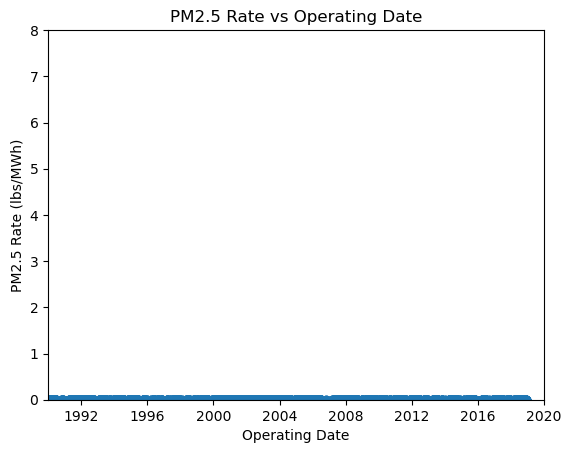

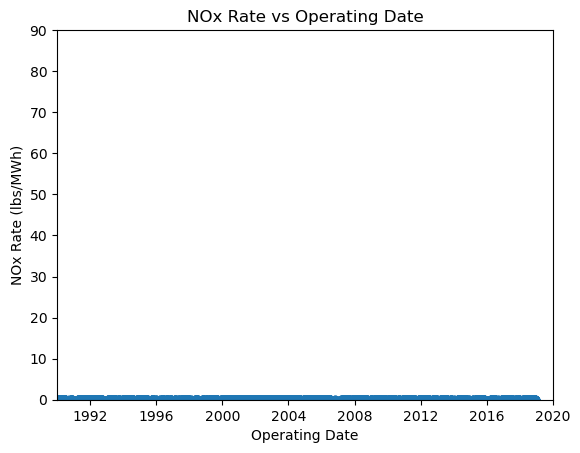

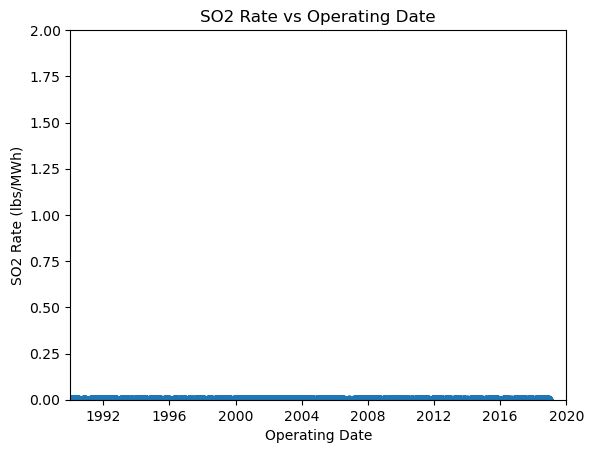

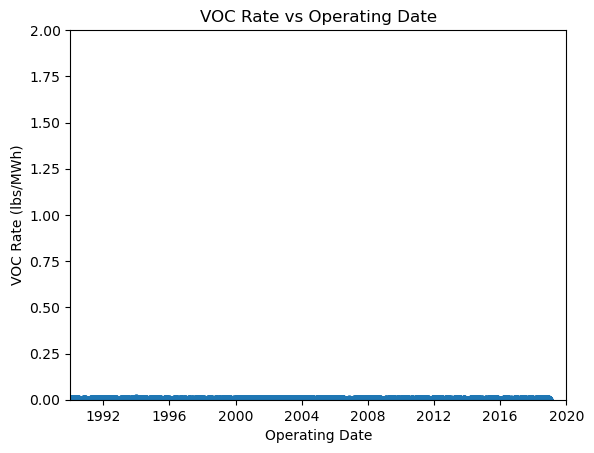

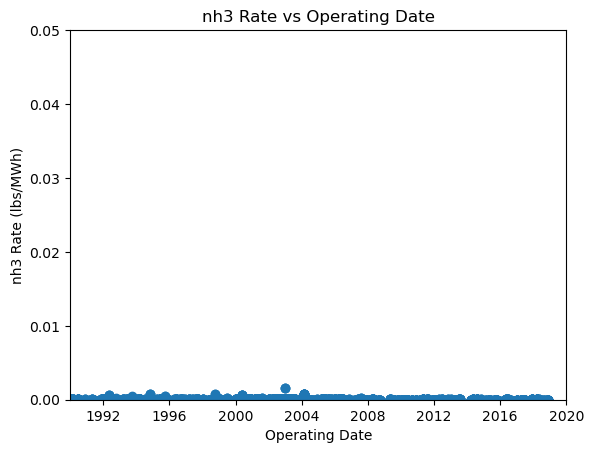

In [124]:
## what rates should we assign to new sources?
## Investigate with some plots

existing_gen_units['operating_date']=pd.to_datetime(existing_gen_units['operating_date'])


plt.scatter(existing_gen_units.query('energy_source_code_1=="NG"')['operating_date'], existing_gen_units.query('energy_source_code_1=="NG"')['pm25_rate'])
plt.ylim(0, 8)
plt.xlim(pd.to_datetime('1990-01-01'),pd.to_datetime('2020-01-01'))
plt.xlabel('Operating Date')
plt.ylabel('PM2.5 Rate (lbs/MWh)')
plt.title('PM2.5 Rate vs Operating Date')
plt.savefig("MIP_AirPollution/Figures/PollutionRatePlots/pm25rate_operatingyear.jpg", dpi=300)
plt.show()

plt.scatter(existing_gen_units.query('energy_source_code_1=="NG"')['operating_date'], existing_gen_units.query('energy_source_code_1=="NG"')['nox_rate'])
plt.ylim(0, 90)
plt.xlim(pd.to_datetime('1990-01-01'),pd.to_datetime('2020-01-01'))
plt.xlabel('Operating Date')
plt.ylabel('NOx Rate (lbs/MWh)')
plt.title('NOx Rate vs Operating Date')
plt.savefig("MIP_AirPollution/Figures/PollutionRatePlots/noxrate_operatingyear.jpg", dpi=300)
plt.show()

plt.scatter(existing_gen_units.query('energy_source_code_1=="NG"')['operating_date'], existing_gen_units.query('energy_source_code_1=="NG"')['so2_rate'])
plt.ylim(0, 2)
plt.xlim(pd.to_datetime('1990-01-01'),pd.to_datetime('2020-01-01'))
plt.xlabel('Operating Date')
plt.ylabel('SO2 Rate (lbs/MWh)')
plt.title('SO2 Rate vs Operating Date')
plt.savefig("MIP_AirPollution/Figures/PollutionRatePlots/so2rate_operatingyear.jpg", dpi=300)
plt.show()

plt.scatter(existing_gen_units.query('energy_source_code_1=="NG"')['operating_date'], existing_gen_units.query('energy_source_code_1=="NG"')['voc_rate'])
plt.ylim(0, 2)
plt.xlim(pd.to_datetime('1990-01-01'),pd.to_datetime('2020-01-01'))
plt.xlabel('Operating Date')
plt.ylabel('VOC Rate (lbs/MWh)')
plt.title('VOC Rate vs Operating Date')
plt.savefig("MIP_AirPollution/Figures/PollutionRatePlots/VOCrate_operatingyear.jpg", dpi=300)
plt.show()

plt.scatter(existing_gen_units.query('energy_source_code_1=="NG"')['operating_date'], existing_gen_units.query('energy_source_code_1=="NG"')['nh3_rate'])
plt.ylim(0, .05)
plt.xlim(pd.to_datetime('1990-01-01'),pd.to_datetime('2020-01-01'))
plt.xlabel('Operating Date')
plt.ylabel('nh3 Rate (lbs/MWh)')
plt.title('nh3 Rate vs Operating Date')
plt.savefig("MIP_AirPollution/Figures/PollutionRatePlots/nh3rate_operatingyear.jpg", dpi=300)
plt.show()


In [125]:
## Calculate emissions rates for new sources

technology_rates_newsources = existing_gen_units[existing_gen_units['operating_date']>=pd.to_datetime('2016-01-01')].groupby(['technology', 'planning_year']).apply(weighted_average).reset_index()

generator_inputs = pd.read_csv("MIP_results_comparison/"+scenario+'/'+model+'_op_inputs/Inputs/Inputs_p1/Generators_data.csv')
### 
#Add in CCS
# Not sure where to draw heat rates from exactly.  It looks like all new NGCT has heat rate of 6.36 and all new CCCCS has heat rate of 7.16
#I'll take this from an inputs file but this will break if naturalgas_ccavg or naturalgas_ccccsavg are associated with more than one heat rate
appendrows = technology_rates_newsources[technology_rates_newsources['technology']=='Natural Gas Fired Combined Cycle']
appendrows['technology'] = 'Natural Gas Fired Combined Cycle With CCS'
generator_inputs = generator_inputs[generator_inputs['Resource'].str.contains('naturalgas_cc')]
generator_inputs = generator_inputs[['technology', 'Heat_Rate_MMBTU_per_MWh']].drop_duplicates()

ccspenalty = float(generator_inputs[generator_inputs['technology'].str.contains('CCCCSAvg')].loc[:,'Heat_Rate_MMBTU_per_MWh'])/float(generator_inputs[generator_inputs['technology'].str.contains('CCAvg')].loc[:,'Heat_Rate_MMBTU_per_MWh'])

ratecolumns=['nox_rate', 'so2_rate', 'pm25_rate', 'nh3_rate', 'voc_rate']
appendrows[ratecolumns]=appendrows[ratecolumns].apply(lambda x: x * ccspenalty)
technology_rates_newsources = pd.concat([technology_rates_newsources, appendrows])


C:\Users\lbeatty\AppData\Local\Temp\ipykernel_804\1399868379.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  appendrows['technology'] = 'Natural Gas Fired Combined Cycle With CCS'
C:\Users\lbeatty\AppData\Local\Temp\ipykernel_804\1399868379.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  appendrows[ratecolumns]=appendrows[ratecolumns].apply(lambda x: x * ccspenalty)


In [126]:
### Now deal with new generation
newgeneration['technology']=np.nan
newgeneration.loc[newgeneration['Resource'].str.contains('_ccavg'), 'technology']= 'Natural Gas Fired Combined Cycle'
newgeneration.loc[newgeneration['Resource'].str.contains('_ctavg'), 'technology']= 'Natural Gas Fired Combustion Turbine'
newgeneration.loc[newgeneration['Resource'].str.contains('_ccccsavg'), 'technology']= 'Natural Gas Fired Combined Cycle With CCS'

#Isolate retired sites -- dates and locations
retired_sites = existing_gen_units.groupby(['EIA_PLANT_ID', 'EIA_GENERATOR_ID', 'region', 'technology'])['planning_year'].max().reset_index()
retired_sites['planning_year']=retired_sites['planning_year']+10
retired_sites = pd.merge(eia860, retired_sites, how='left', on=['EIA_PLANT_ID', 'EIA_GENERATOR_ID']).reset_index()
retired_sites = pd.merge(retired_sites, plants, how='left', on=['EIA_PLANT_ID'])

#get retirement date from eia860, then round up to nearest 10
retired_sites['RetirementPeriod860']=pd.to_numeric(retired_sites['RetirementYear'], errors='coerce', downcast='float')
retired_sites['RetirementPeriod860']=retired_sites['RetirementPeriod860']/10
retired_sites['RetirementPeriod860']=retired_sites['RetirementPeriod860'].apply(np.ceil)*10

retired_sites['RetirementPeriod'] = retired_sites['planning_year'].combine_first(retired_sites['RetirementPeriod860'])
ipm_regions = gpd.read_file('Data/IPM_Regions/national_emm_boundaries.shp')

C:\Users\lbeatty\AppData\Local\Temp\ipykernel_804\1142174358.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newgeneration['technology']=np.nan
C:\Users\lbeatty\AppData\Local\Temp\ipykernel_804\1142174358.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newgeneration.loc[newgeneration['Resource'].str.contains('_ccavg'), 'technology']= 'Natural Gas Fired Combined Cycle'


In [127]:
#make retired sites a geopandas
geometry = [Point(lon, lat) for lon, lat in zip(retired_sites['Longitude'], retired_sites['Latitude'])]
retired_sites_geo = gpd.GeoDataFrame(retired_sites, geometry=geometry, crs='EPSG:4326')

In [128]:
#ipm_regions['region'] = ipm_regions['IPM_Region'].map({region: val for val, regions in cost_multiplier_region_map.items() for region in regions})
ipm_regions = ipm_regions.to_crs('EPSG:4326')

retired_sites_geo = gpd.sjoin(retired_sites_geo, ipm_regions, how="left", op="intersects")

c:\Users\lbeatty\AppData\Local\miniforge3\envs\powergenome\lib\site-packages\IPython\core\interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<bound method NDFrame.head of    model_regi    region             x             y  \
0        BASN   WECC_ID -1.539230e+06  2.095757e+06   
1        CANO  WEC_BANC -2.161934e+06  2.018298e+06   
2        CASO  WEC_LADW -1.916067e+06  1.555589e+06   
3        FRCC      FRCC  1.384001e+06  6.823118e+05   
4        ISNE   NENG_CT  1.992209e+06  2.623107e+06   
5        MISC    MIS_IL  5.539238e+05  1.802351e+06   
6        MISE   MIS_LMI  9.173750e+05  2.338542e+06   
7        MISS  MIS_AMSO  4.139155e+05  1.040307e+06   
8        MISW    MIS_IA  1.587086e+04  2.526196e+06   
9        NWPP   WECC_MT -1.628495e+06  2.733482e+06   
10       NYCW    NY_Z_J  1.891715e+06  2.206903e+06   
11       NYUP    NY_Z_A  1.641025e+06  2.401311e+06   
12       PJMC  PJM_COMD  5.741554e+05  2.078340e+06   
13       PJMD   PJM_Dom  1.593121e+06  1.740088e+06   
14       PJME  PJM_EMAC  1.615012e+06  2.091724e+06   
15       PJMW    PJM_AP  1.201329e+06  1.907795e+06   
16       RMRG   WECC_CO -8.602443e+

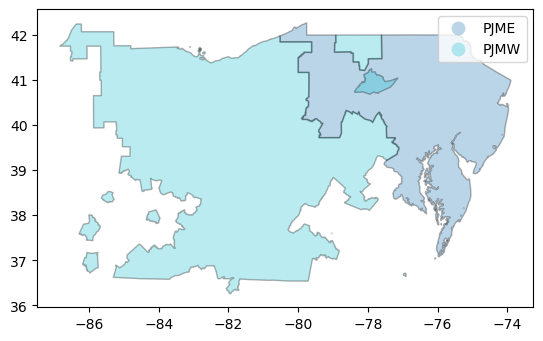

In [129]:
print(ipm_regions.head)
ipm_regions[ipm_regions['model_regi'].isin(['PJMW', 'PJME'])].plot(column='model_regi',edgecolor='black', linewidth=1, legend=True, alpha=0.3)
plt.show()

## There's some overlapping between regions which leads to multiple matches for some retired units which messes things up

In [130]:
retired_sites_df = pd.DataFrame(retired_sites_geo[['EIA_PLANT_ID', 'EIA_GENERATOR_ID', 'region_left', 'model_regi','Technology', 'Longitude', 'Latitude', 'planning_year', 'RetirementPeriod860','RetirementPeriod', 'Capacity']])
retired_sites_df = retired_sites_df.dropna(subset=['RetirementPeriod','model_regi'])
retired_sites_df = retired_sites_df[retired_sites_df['Technology'].str.contains('Natural Gas')]

# look for plants matched with multiple model regions
rowcount = retired_sites_df.groupby(['EIA_PLANT_ID', 'EIA_GENERATOR_ID', 'RetirementPeriod']).size().reset_index()
rowcount.columns = ['EIA_PLANT_ID', 'EIA_GENERATOR_ID', 'RetirementPeriod', 'rowcount']
retired_sites_df = pd.merge(retired_sites_df, rowcount, how='left', on=['EIA_PLANT_ID', 'EIA_GENERATOR_ID', 'RetirementPeriod'])
#drop ones where model_regi!=zone
cond1 = (retired_sites_df['model_regi']!=retired_sites_df['region_left'])
cond2 = (retired_sites_df['rowcount']>1)
retired_sites_df = retired_sites_df[~(cond1 & cond2)]

#check again
#rowcount = retired_sites_df.groupby(['EIA_PLANT_ID', 'EIA_GENERATOR_ID', 'planning_year'])

#make sites retired by 2030 show up in subsequent periods, etc
retired_sites_2030 = retired_sites_df[retired_sites_df['RetirementPeriod']<=2030]
retired_sites_2030['RetirementPeriod']=2030

retired_sites_2040 = retired_sites_df[retired_sites_df['RetirementPeriod']<=2040]
retired_sites_2040['RetirementPeriod']=2040

retired_sites_2050 = retired_sites_df[retired_sites_df['RetirementPeriod']<=2050]
retired_sites_2050['RetirementPeriod']=2050

retired_sites_df = pd.concat([retired_sites_2030, retired_sites_2040, retired_sites_2050])
print(retired_sites_df.shape[0])
#want to distribute new capacity evenly to retired sites
#be agnostic about type of natural gas plant -- eg new cc capacity can go at an old ct site
retired_sites_tech_total= retired_sites_df.groupby(['model_regi', 'RetirementPeriod']).agg({'Capacity':'sum'}).reset_index()
retired_sites_tech_total.columns = ['model_regi','RetirementPeriod', 'Tech_Tot_Retired_Capacity']

retired_sites_df = pd.merge(retired_sites_df, retired_sites_tech_total, how='left', on=['RetirementPeriod', 'model_regi'])
retired_sites_df['Pct_retired_capacity']=retired_sites_df['Capacity']/retired_sites_df['Tech_Tot_Retired_Capacity']
retired_sites_df['planning_year']=retired_sites_df['RetirementPeriod']
retired_sites_df = retired_sites_df.rename(columns={'model_regi': 'zone'})
#save remaining capacity will get updated iteratively
retired_sites_df['RemainingCapacity']=retired_sites_df['Capacity']
print(retired_sites_df.shape[0])


techlist = ['ccavgcf_moderate_0', 'ctavgcf_moderate_0', '_ccccsavgcf_conservative_0']
newgen = pd.DataFrame()
excess = pd.DataFrame()

for tech in techlist:
    capacity_temp = capacity[capacity['resource_name'].str.contains(tech)]
    retired_sites_temp = pd.merge(retired_sites_df, capacity_temp, how='outer', on=['zone', 'planning_year'])  #outer catches all of the region-years with new capacity but no retired plants
    retired_sites_temp['newcapacity'] = retired_sites_temp['Pct_retired_capacity']*retired_sites_temp['end_value']

    #save excess to be distributed to existing plants as a column value
    retired_sites_temp['excess_capacity'] = retired_sites_temp['RemainingCapacity']-retired_sites_temp['newcapacity']
    retired_sites_temp['excess_capacity'][retired_sites_temp['excess_capacity'].isna()]=-1*retired_sites_temp['end_value'][retired_sites_temp['excess_capacity'].isna()]

    #limit new capacity to be no greater than retired capacity
    retired_sites_temp['newcapacity']=retired_sites_temp[['RemainingCapacity', 'newcapacity']].min(axis=1)

    #save excess
    excess_temp = retired_sites_temp[retired_sites_temp['excess_capacity']<0]
    excess_temp = excess_temp.groupby(['planning_year', 'resource_name', 'zone']).agg({'excess_capacity':'sum'}).reset_index()
    excess = pd.concat([excess, excess_temp], ignore_index=True)

    #save new capacity
    retired_sites_newgen = retired_sites_temp.dropna(subset=['Capacity'])
    retired_sites_newgen = retired_sites_newgen[['newcapacity', 'resource_name','planning_year', 'Longitude', 'Latitude']]
    newgen = pd.concat([newgen, retired_sites_newgen], ignore_index=True)

    #update remaining capacity
    retired_sites_temp = retired_sites_temp.dropna(subset=['Capacity'])
    retired_sites_temp['RemainingCapacity']=retired_sites_temp['Capacity']-retired_sites_temp['newcapacity']
    retired_sites_temp = retired_sites_temp[['EIA_PLANT_ID', 'EIA_GENERATOR_ID', 'RemainingCapacity', 'planning_year']]
    retired_sites_df = pd.merge(retired_sites_df, retired_sites_temp, how='left', on=['EIA_PLANT_ID', 'EIA_GENERATOR_ID', 'planning_year'])
    retired_sites_df['RemainingCapacity']=retired_sites_df['RemainingCapacity_y']
    retired_sites_df.drop(['RemainingCapacity_x', 'RemainingCapacity_y'], axis=1, inplace=True)
    print(retired_sites_df.shape[0])

1000
1000
1000
1000
1000


C:\Users\lbeatty\AppData\Local\Temp\ipykernel_804\902358228.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retired_sites_2030['RetirementPeriod']=2030
C:\Users\lbeatty\AppData\Local\Temp\ipykernel_804\902358228.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retired_sites_2040['RetirementPeriod']=2040
C:\Users\lbeatty\AppData\Local\Temp\ipykernel_804\902358228.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [131]:
##########
## Now distribute excess gen to existing plants
newgen_existingunits = existing_gen_units.copy()
newgen_existingunits = newgen_existingunits[newgen_existingunits['technology'].str.contains('Natural Gas')]
#merge in total capacity or total net gen
excess.columns = ['planning_year', 'resource_name', 'region', 'excess_capacity']
newgen_existingunits = pd.merge(newgen_existingunits, excess, on=['planning_year', 'region'], how='left')

technology_year_total = newgen_existingunits.groupby(['resource_name', 'planning_year', 'region']).agg({column : 'sum'}).reset_index()
technology_year_total.columns = ['resource_name', 'planning_year', 'region', 'technology_total']
newgen_existingunits = pd.merge(newgen_existingunits, technology_year_total, how='left', on=['resource_name', 'planning_year', 'region'])

newgen_existingunits['pct_total']=newgen_existingunits[column]/newgen_existingunits['technology_total_y']
test = newgen_existingunits.groupby(['resource_name', 'planning_year', 'region']).agg({'pct_total':'sum'}).reset_index()
newgen_existingunits['newcapacity']=newgen_existingunits['excess_capacity']*newgen_existingunits['pct_total']*-1

newgen_existingunits = newgen_existingunits[['newcapacity', 'region', 'planning_year', 'resource_name', 'Longitude', 'Latitude', 'EIA_PLANT_ID', 'EIA_GENERATOR_ID', 'pct_total']]
test = newgen_existingunits.groupby(['resource_name', 'planning_year', 'region']).agg({'pct_total':'sum'}).reset_index()

newgen = pd.concat([newgen, newgen_existingunits], ignore_index=True)
newgen['retiredsite']=newgen['EIA_PLANT_ID'].isna()

test = newgen.groupby(['resource_name', 'planning_year', 'retiredsite']).agg({'newcapacity':'sum', 'pct_total':'sum'}).reset_index()


In [132]:
######
# Test to see if you allocated the correct amount of new capacity
test = newgen.groupby(['resource_name', 'planning_year']).agg({'newcapacity':'sum', 'pct_total':'sum'})
test = pd.merge(test, capacity, how='left', on=['resource_name', 'planning_year'])
test['dif'] = test['end_value']-test['newcapacity']
test['dif'] = test['dif'].abs()
maxdif = test['dif'].max()
def check_value(value):
    if value > 0.001:  #gives a little bit of wiggle room
        raise ValueError("New capacity was not allocated correctly. Check code.")

try:
    check_value(maxdif)
except ValueError as e:
    print(f"Error: {e}")

In [133]:
#################
## Distribute newgeneration to newgen (capacities) weighted by capacity

newgen = newgen.rename(columns={'resource_name': 'Resource'})
newgen = pd.merge(newgen, newgeneration, on=['Resource', 'planning_year'], how='left')
newgen = pd.merge(newgen, technology_rates_newsources, on=['technology', 'planning_year'])

In [134]:
#############
## Same schtick as before - determine a source's share of cluster-level capacity, then allocate generation based on that percentage

newgen_cap_totals = newgen.groupby(['Resource', 'planning_year']).agg({'newcapacity':'sum'}).reset_index()
newgen_cap_totals.columns = ['Resource', 'planning_year', 'sum_tot_cap']

newgen = pd.merge(newgen, newgen_cap_totals, how='left', on=['Resource', 'planning_year'])

In [135]:
newgen['pct_cap']=newgen['newcapacity']/newgen['sum_tot_cap']
newgen['predicted_gen']=newgen['value']*newgen['pct_cap']

newgen['nox_predicted']=newgen['predicted_gen']*newgen['nox_rate']
newgen['so2_predicted']=newgen['predicted_gen']*newgen['so2_rate']
newgen['pm25_predicted']=newgen['predicted_gen']*newgen['pm25_rate']
newgen['voc_predicted']=newgen['predicted_gen']*newgen['voc_rate']
newgen['nh3_predicted']=newgen['predicted_gen']*newgen['nh3_rate']


In [136]:
#bind all emissions sources together
emissions=pd.concat([existing_gen_units, newgen], ignore_index=True)
test_emissions_2020['planning_year']=2020
emissions = pd.concat([emissions, test_emissions_2020], ignore_index=True)


In [137]:
#make output folders

#folder for emissions output
if not os.path.exists('InMap/MIP_Emissions/'+scenario+'/'+model):
    os.makedirs('InMap/MIP_Emissions/'+scenario+'/'+model+'/')

#folder for inmap output
if not os.path.exists('InMap/MIP_InMap_Output/'+scenario+'/'+model):
    os.makedirs('InMap/MIP_InMap_Output/'+scenario+'/'+model+'/')

## 6. Split the emissions output by planning year and write to shapefiles.

In [138]:
#####
## 2020
#####
emissions_2020 = emissions.query('planning_year==2020')

emissions_2020 = emissions_2020[['Longitude', 'Latitude', 'nox_predicted', 'so2_predicted', 'pm25_predicted', 'voc_predicted', 'nh3_predicted']]
emissions_2020.columns = ['Longitude', 'Latitude', 'NOx', 'SOx', 'PM2_5', 'VOC', 'NH3']

emissions_2020 = gpd.GeoDataFrame(
    emissions_2020, geometry = gpd.points_from_xy(emissions_2020.Longitude, emissions_2020.Latitude), crs='EPSG:4326')

emissions_2020 = emissions_2020.dropna().reset_index(drop=True)

emissions_2020.to_file(filename='InMap/MIP_Emissions/'+scenario+'/'+model+'/emissions_2020.shp')

#####
## 2030
#####
emissions_2030 = emissions.query('planning_year==2030')

emissions_2030 = emissions_2030[['Longitude', 'Latitude', 'nox_predicted', 'so2_predicted', 'pm25_predicted', 'voc_predicted', 'nh3_predicted']]
emissions_2030.columns = ['Longitude', 'Latitude', 'NOx', 'SOx', 'PM2_5', 'VOC', 'NH3']

emissions_2030 = gpd.GeoDataFrame(
    emissions_2030, geometry = gpd.points_from_xy(emissions_2030.Longitude, emissions_2030.Latitude), crs='EPSG:4326')

emissions_2030 = emissions_2030.dropna().reset_index(drop=True)

emissions_2030.to_file(filename='InMap/MIP_Emissions/'+scenario+'/'+model+'/emissions_2030.shp')

#####
## 2040
#####

emissions_2040 = emissions.query('planning_year==2040')

emissions_2040 = emissions_2040[['Longitude', 'Latitude', 'nox_predicted', 'so2_predicted', 'pm25_predicted', 'voc_predicted', 'nh3_predicted']]
emissions_2040.columns = ['Longitude', 'Latitude', 'NOx', 'SOx', 'PM2_5', 'VOC', 'NH3']

emissions_2040 = gpd.GeoDataFrame(
    emissions_2040, geometry = gpd.points_from_xy(emissions_2040.Longitude, emissions_2040.Latitude), crs='EPSG:4326')

emissions_2040 = emissions_2040.dropna().reset_index(drop=True)

emissions_2040.to_file(filename='InMap/MIP_Emissions/'+scenario+'/'+model+'/emissions_2040.shp')

#####
## 2050
#####

emissions_2050 = emissions.query('planning_year==2050')

emissions_2050 = emissions_2050[['Longitude', 'Latitude', 'nox_predicted', 'so2_predicted', 'pm25_predicted', 'voc_predicted', 'nh3_predicted']]
emissions_2050.columns = ['Longitude', 'Latitude', 'NOx', 'SOx', 'PM2_5', 'VOC', 'NH3']

emissions_2050 = gpd.GeoDataFrame(
    emissions_2050, geometry = gpd.points_from_xy(emissions_2050.Longitude, emissions_2050.Latitude), crs='EPSG:4326')

emissions_2050 = emissions_2050.dropna().reset_index(drop=True)


emissions_2050.to_file(filename='InMap/MIP_Emissions/'+scenario+'/'+model+'/emissions_2050.shp')



In [139]:
### Write total emissions to a csv

tot_emissions = emissions.groupby(['planning_year']).agg({'nox_predicted':'sum', 'so2_predicted':'sum', 'pm25_predicted':'sum', 'voc_predicted':'sum', 'nh3_predicted':'sum'}).reset_index()
tot_emissions['model']=model
tot_emissions['scenario']=scenario
tot_emissions['date_stamp']=pd.to_datetime('today').date()

print(tot_emissions)

tot_emissions.to_csv('MIP_AirPollution/emis.csv', mode='a', index=False, header=False)

#Now do by technology
tot_emissions = emissions.groupby(['planning_year', 'technology']).agg({'nox_predicted':'sum', 'so2_predicted':'sum', 'pm25_predicted':'sum', 'voc_predicted':'sum', 'nh3_predicted':'sum'}).reset_index()
tot_emissions['model']=model
tot_emissions['scenario']=scenario
tot_emissions['date_stamp']=pd.to_datetime('today').date()

print(tot_emissions)

tot_emissions.to_csv('MIP_AirPollution/emis_detail.csv', mode='a', index=False, header=False)



   planning_year  nox_predicted  so2_predicted  pm25_predicted  voc_predicted  \
0           2020  773004.858795  742944.625857    96120.625578   23036.790886   
1           2030  699198.973802  884614.599625    75593.424651   16476.843004   
2           2040  384980.485689  470197.511277    57669.501395   12742.970392   
3           2050  226763.971437  107286.160604    66860.798343   16114.559610   

   nh3_predicted model                    scenario  date_stamp  
0   33691.454319  GenX  26z-short-current-policies  2024-02-13  
1   16308.006656  GenX  26z-short-current-policies  2024-02-13  
2   21056.889385  GenX  26z-short-current-policies  2024-02-13  
3   33030.572607  GenX  26z-short-current-policies  2024-02-13  
    planning_year                                   technology  nox_predicted  \
0            2020                                    All Other       0.000000   
1            2020                                    Batteries       0.000000   
2            2020  Coal In

## List of open questions

1. What do I do about generators with negative net gen?  This makes emissions rates negative but if I just call them zero I'd be biasing plant-level emissions upwards.
2. Do we care about stack height? 
3. When to interpolate?  Can interpolate generation but then we'd need to run the pollution model a bunch.  Could also interpolate air concentrations -- leaning towards this.


In [140]:
test = emissions
test['nox_delta']=test['nox_tons']-test['nox_predicted']
print(test['nox_delta'].mean())
print(test['nox_delta'].quantile(0.9))

test['so2_delta']=test['so2_tons']-test['so2_predicted']
print(test['so2_delta'].mean())
print(test['so2_delta'].quantile(0.9))

test['pm25_delta']=test['pm25_tons']-test['pm25_predicted']
print(test['pm25_delta'].mean())
print(test['pm25_delta'].quantile(0.9))

test['gen_delta']=test['predicted_gen']-test['NET_GEN_GENERATOR']
print(test['gen_delta'].mean())
print(test['gen_delta'].quantile(0.9))


-6.837320027671341
92.70179208536656
-47.9988472333022
3.1779201986476737
6.145859916361724
29.126287469509784
-203758.641832186
108205.0420393424
